# Target selection for polygon vertex/spacing descriptor
We try to do something here.

In [652]:
# Imports
# Note: Must be available in the virtual env t2t-env (see install.sh in the root folder)
import math
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from random import random
from sympy import Point, Circle, intersection

Accessory functions

In [314]:
def gen_point():
    return (random(), random())

def get_ang(x, y, cx = 0, cy = 0):
    return math.atan2(y-cy, x-cx)

def get_center(points):
    xs, ys = zip(*points)
    cx = min(xs)+(max(xs)-min(xs))/2
    cy = min(ys)+(max(ys)-min(ys))/2
    return (cx, cy)

## Creating polygons
Randomized creation.

Functions for computing quantities

In [315]:
# Sum of all sides' lengths
def compute_perimeter(points):
    sum = 0
    for i in range(len(points)-1):
        x1, y1 = points[i]
        x2, y2 = points[i+1]
        sum = sum + math.sqrt((x1-x2)**2 + (y1-y2)**2)
    
    return round(sum, 4)

# Area of the polygon
# Shoelace formula: https://en.wikipedia.org/wiki/Shoelace_formula
def compute_surface(points):
    sum2 = 0
    for i in range(len(points)-1):
        x1, y1 = points[i]
        x2, y2 = points[i+1]
        sum2 = sum2 + x1*y2 - x2*y1
    
    return round(sum2/2, 4)

def get_centroid(points):
    S = compute_surface(points)
    Cx, Cy = 0, 0
    
    for i in range(len(points)-1):
        x1, y1 = points[i]
        x2, y2 = points[i+1]
        Cx = Cx + (x1 + x2)*(x1*y2 - x2*y1)
        Cy = Cy + (y1 + y2)*(x1*y2 - x2*y1)
    
    return (1/(6*S))*Cx, (1/(6*S))*Cy

# Sum of the distances between each vertex and the centroid
def compute_centroid(points):
    # Find the centroid point
    Cx, Cy = get_centroid(points)
    
    # Compute the sum of distances between C and all vertices
    sum = 0
    for x,y in points:
        sum = sum + math.sqrt((Cx-x)**2 + (Cy-y)**2)
    
    return round(sum, 4)

Functions for creating polygons:

In [313]:
# Creates a polygon
def create_poly(N):
    points = [gen_point() for n in range(N)]
    C = get_center(points)
    points = sorted(points, key = lambda p: get_ang(p[0], p[1], C[0], C[1]))
    points.append(points[0]) # Repeat the first point to create a 'closed loop'
    return points

# Creates a polygon and associates quantities
def create_poly_info(N):
    points = create_poly(N)
    return {
        'points': points,
        'perimeter': compute_perimeter(points),
        'surface': compute_surface(points),
        'centroid': compute_centroid(points)
    }

# Creates M polygons of N vertices with associated infos
def create_n_poly(N, M):
    return [create_poly_info(N) for n in range(M)]

Displaying utilities

In [361]:
def draw_poly(poly, show_centroid=False):
    points = poly['points']
    xs, ys = zip(*points)
    
    plt.figure()
    plt.plot(xs, ys)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    if show_centroid:
        Cx, Cy = get_centroid(points)
        plt.plot([Cx], [Cy], marker='^', ls='none', ms=10, mfc='red')
    
    plt.show()

def draw_n_poly(polys, col_n):
    fig = plt.figure()
    columns = col_n
    rows = len(polys)//col_n + len(polys)%col_n
    
    for i in range(1, columns*rows+1):
        points = polys[i-1]['points']
        P = polys[i-1]['perimeter']
        S = polys[i-1]['surface']
        C = polys[i-1]['centroid']
        
        xs, ys = zip(*points)
        ax = fig.add_subplot(rows, columns, i, aspect=1)
        plt.plot(xs, ys)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.annotate(f'P={P}', xy=(0.01,0.02), fontsize=6)
        ax.annotate(f'S={S}', xy=(0.01,0.13), fontsize=6)
        ax.annotate(f'C={C}', xy=(0.01,0.24), fontsize=6)
        
    plt.show()

Drawing some random configurations of points and the polygons they generate.

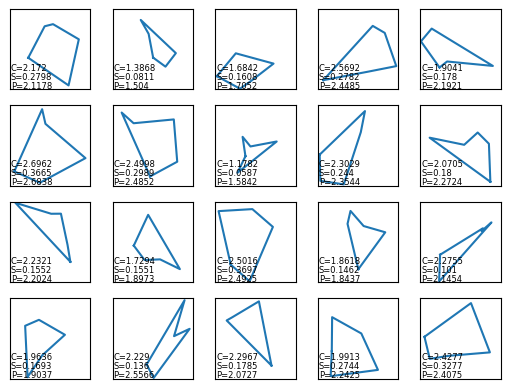

In [362]:
draw_n_poly(create_n_poly(5, 20), 5)

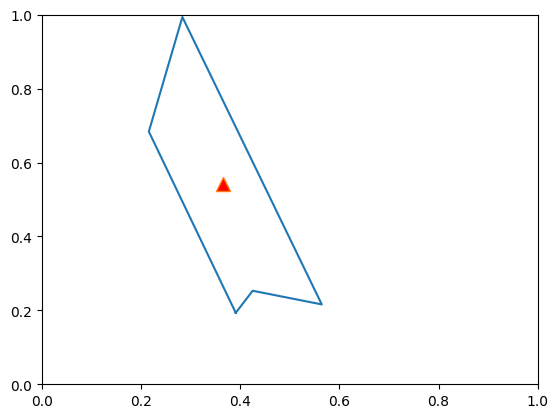

In [364]:
draw_poly(create_poly_info(5), True)

## Degree of separation
We introduce a quantity called _degree of separation_ (DoS). This helps us understanding which metric to use as the target quantity to optimize analytically. The DoS is a non-analytical quantity which is computed numerically and by running simulations.

The procedure is simply: circles are drawn at each vertex of the polygon starting with a small radius. All circles have the same radii. At each iteration, we check that there exist no intersection between each pair of circles. When such condition holds, the radius is increased by a small delta and the procedure repeats until at leats one intersection is found.

$$
\rho = \underset{R}{\operatorname{argmax}} \left| \bigcup_{C_i, C_j} C_i \cap C_j \right|
$$

Defining functions to implement hit-testing

In [443]:
# Returns a value indicating whether the specified radius generates intersections in the vertex circles
# This can be user to test whether a certain radius is a valid DoS
def poly_r_hit_test(points, radius):
    circles = [Circle(Point(x, y), radius) for x,y in points[:-1]]
    for c1 in circles:
        for c2 in circles:
            if c1 is c2:
                continue
            if not intersection(c1, c2):
                continue
            else:
                return False
    return True

Displaying utility for visualizing the hit-test.

In [455]:
def draw_poly_dos(poly, radius):
    points = poly['points']
    xs, ys = zip(*points)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(xs, ys)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    hit_test = not poly_r_hit_test(points, radius)
    ax.annotate(f'R={radius}', xy=(0.01,0.02), fontsize=10)
    ax.annotate(f'hit={hit_test}', xy=(0.01,0.1), fontsize=10)
    
    for x,y in points[:-1]:
        circle = plt.Circle((x, y), radius, fill=False, ls='--', ec='r', alpha=0.5)
        ax.add_patch(circle)
    
    plt.show()

def draw_poly_n_dos(poly, radii):
    points = poly['points']
    xs, ys = zip(*points)
    
    fig = plt.figure()
    columns, rows = len(radii), 1
    
    for i in range(1, columns*rows+1):
        ax = fig.add_subplot(rows, columns, i, aspect=1)
        plt.plot(xs, ys)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.annotate(f'R={radii[i-1]}', xy=(0.01,0.02), fontsize=6)
        hit_test = not poly_r_hit_test(points, radii[i-1])
        ax.annotate(f'hit={hit_test}', xy=(0.01,0.13), fontsize=6)
        
        for x,y in points[:-1]:
            ax.add_patch(plt.Circle((x, y), radii[i-1], fill=False, ls='--', ec='r', alpha=0.5))
    
    plt.show()

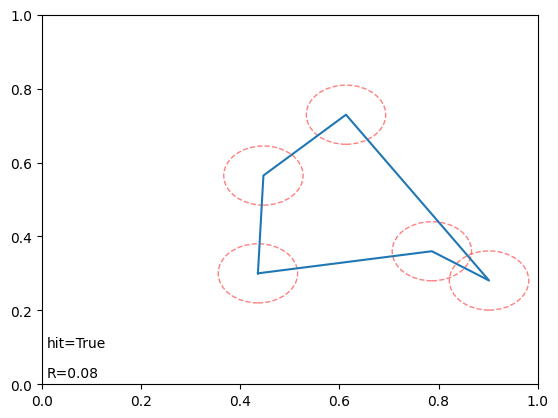

In [454]:
draw_poly_dos(create_poly_info(5), 0.08)

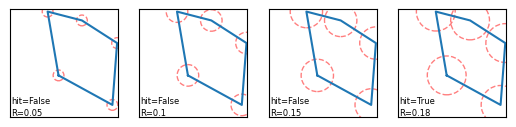

In [474]:
poly_hit_eval = create_poly_info(5)
draw_poly_n_dos(poly_hit_eval, [0.05, 0.1, 0.15, 0.18])

### Algorithm for finding the DoS
The DoS $\rho$ can be found by iterative trials.

In [523]:
# Using the hit-test, find out the max radius for which there is no hit
def compute_dos(points, start=0.02, rstep=0.02):
    prev_r = 0 # If this gets returned, then we got a hit already at start, more granularity needed
    for r in np.arange(start, 1, rstep):
        if not poly_r_hit_test(points, r):
            return prev_r
        prev_r = round(r, 2)
    return -1 # Something went wrong

Testing the algorithm with an example

In [524]:
compute_dos(poly_hit_eval['points'])

0.16

## Simulations
We now perform some simulations:

1. Create a polygon
2. Compute all quantities: perimeter, surface, centroid distance
3. Compute the DoS $\rho$

The goal is the following:

> Evaluate the trend of the 3 candidate target quantities $m_k$ against $\rho$. We want to select the quantities which exhibit a monotonic increasing trend on $m_k = f(\rho)$.

In [479]:
def simulate(N, M):
    polys = create_n_poly(N, M)
    for poly_info in polys:
        poly_info['dos'] = compute_dos(poly_info['points'])
    
    return polys

In [610]:
sim_num = 60
sim_poly_vertex_count = 5
sim = simulate(sim_poly_vertex_count, sim_num) # Run simulations

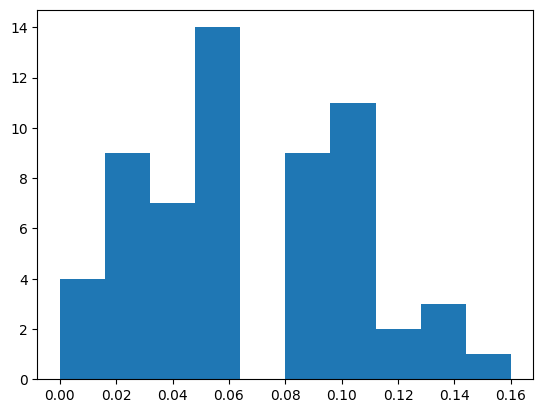

In [612]:
# Display an overview
sim_data = [x['dos'] for x in sim]
hist, bin_edges = np.histogram(sim_data, density=False)
plt.hist(bin_edges[:-1], bin_edges, weights=hist)
plt.show()

Displaying utilities for simulations

In [515]:
def draw_simulations(polys, col_n):
    fig = plt.figure()
    columns = col_n
    rows = len(polys)//col_n + len(polys)%col_n
    
    for i in range(1, columns*rows+1):
        points = polys[i-1]['points']
        P = polys[i-1]['perimeter']
        S = polys[i-1]['surface']
        C = polys[i-1]['centroid']
        dos = polys[i-1]['dos']
        
        xs, ys = zip(*points)
        ax = fig.add_subplot(rows, columns, i, aspect=1)
        plt.plot(xs, ys)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.annotate(f'P={P}', xy=(0.01,0.02), fontsize=6)
        ax.annotate(f'S={S}', xy=(0.01,0.13), fontsize=6)
        ax.annotate(f'C={C}', xy=(0.01,0.24), fontsize=6)
        ax.annotate(f'R={dos}', xy=(0.01,0.92), fontsize=6, c='r')
        
    plt.show()

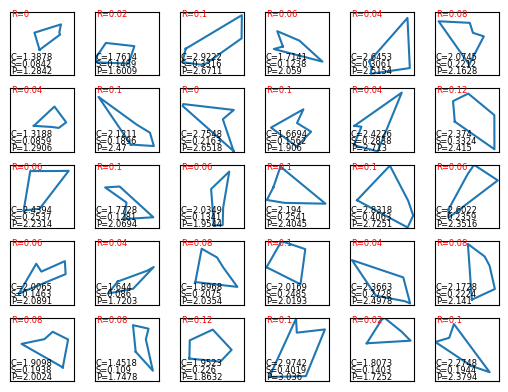

In [613]:
draw_simulations(sim[:30], 6) # Display the first n simulations

### Simulation results
Running simulations.

Result plotting utilities:

In [565]:
def extract_simulation_results(polys):
    # Order the polygon infos by incresing DoS
    sorted_polys = sorted(polys, key = lambda p: p['dos'])
    # Extract relevant quantities
    values = [(p['dos'], p['perimeter'], p['surface'], p['centroid']) for p in sorted_polys]
    
    return values

def plot_simulation_results(polys, display='psc'):
    results = extract_simulation_results(polys)
    r, p, s, c = zip(*results)
    
    plt.figure()
    if 'p' in display:
        plt.scatter(r, p, marker='x')
    if 's' in display:
        plt.scatter(r, s, marker='o')
    if 'c' in display:
        plt.scatter(r, c, marker='^')
    
    plt.show()

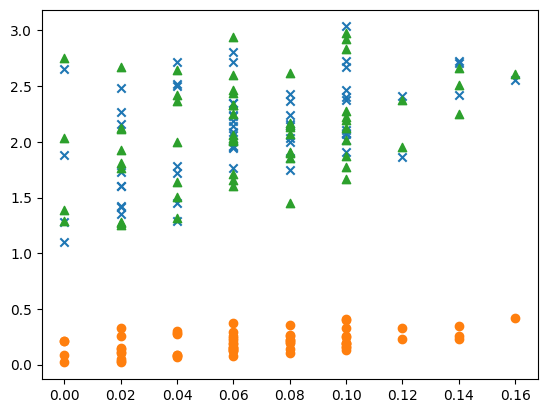

In [614]:
plot_simulation_results(sim, display='psc')

In [617]:
sim_res = extract_simulation_results(sim)
sim_res[:10]

[(0, 1.2842, 0.0842, 1.3878),
 (0, 2.6518, 0.2163, 2.7548),
 (0, 1.8827, 0.2149, 2.0327),
 (0, 1.097, 0.0196, 1.2871),
 (0.02, 1.6009, 0.1489, 1.7614),
 (0.02, 1.7252, 0.1403, 1.8073),
 (0.02, 2.268, 0.1068, 2.12),
 (0.02, 1.3518, 0.0356, 1.2711),
 (0.02, 2.4836, 0.3327, 2.6722),
 (0.02, 2.1567, 0.2595, 2.1241)]

### Regression analysis
We could not really find a monotonic trend, we use ML and Linear Regression to select the best target quantity. The selection process will be based on the degree of correlation expressed by the regression coefficient relating to the corresponding predictor.

In [684]:
def linreg(xs, ys):
    X = xs
    X = sm.add_constant(X)
    Y = ys
    model = sm.OLS(Y, X)
    results = model.fit()
    return results

def linreg_res(xs, ys, results):
    p0, p1 = results.params
    res_xs = np.linspace(min(xs), max(xs), 100)
    res_ys = [p1*x + p0 for x in res_xs]
    return [res_xs, res_ys, p1]

Run 3 separate linear regressions.

In [696]:
sim_res_reg_r, sim_res_reg_p, sim_res_reg_s, sim_res_reg_c = zip(*sim_res)

linreg_res_p = linreg(sim_res_reg_p, sim_res_reg_r)
linreg_res_s = linreg(sim_res_reg_s, sim_res_reg_r)
linreg_res_c = linreg(sim_res_reg_c, sim_res_reg_r)

print(linreg_res_p.summary())
print(linreg_res_s.summary())
print(linreg_res_c.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     19.89
Date:                Wed, 26 Apr 2023   Prob (F-statistic):           3.82e-05
Time:                        20:19:36   Log-Likelihood:                 119.70
No. Observations:                  60   AIC:                            -235.4
Df Residuals:                      58   BIC:                            -231.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0293      0.022     -1.348      0.1

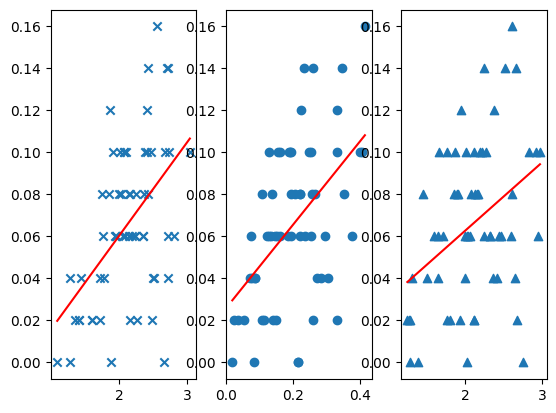

In [697]:
linreg_p = linreg_res(sim_res_reg_p, sim_res_reg_r, linreg_res_p)
linreg_s = linreg_res(sim_res_reg_s, sim_res_reg_r, linreg_res_s)
linreg_c = linreg_res(sim_res_reg_c, sim_res_reg_r, linreg_res_c)

fig = plt.figure()

ax1 = fig.add_subplot(1, 3, 1, aspect='auto')
plt.scatter(sim_res_reg_p, sim_res_reg_r, marker='x')
plt.plot(linreg_p[0], linreg_p[1], c='r')

ax2 = fig.add_subplot(1, 3, 2, aspect='auto')
plt.scatter(sim_res_reg_s, sim_res_reg_r, marker='o')
plt.plot(linreg_s[0], linreg_s[1], c='r')

ax3 = fig.add_subplot(1, 3, 3, aspect='auto')
plt.scatter(sim_res_reg_c, sim_res_reg_r, marker='^')
plt.plot(linreg_c[0], linreg_c[1], c='r')

plt.show()

In [698]:
(linreg_p[2], linreg_s[2], linreg_c[2])

(0.04477269158097713, 0.19871618854235898, 0.032567913964892975)

#### Multi-regression
The best approach would be to run a multi-regression:

$$
\rho = \beta_0 + \beta_P P + \beta_S S + \beta_C C
$$

In [734]:
def multlinreg(simres):
    A = np.array(simres)
    X = A[:,1:4] # Take the last 3 columns
    X = sm.add_constant(X)
    Y = A[:,0] # Take the 1st column
    model = sm.OLS(Y, X)
    results = model.fit()
    return results

In [736]:
# Run the multi regression
# x1 = perimeter
# x2 = surface
# x3 = centroid
multilinreg_res = multlinreg(sim_res)

print(multilinreg_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     11.26
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           6.94e-06
Time:                        21:56:32   Log-Likelihood:                 125.02
No. Observations:                  60   AIC:                            -242.0
Df Residuals:                      56   BIC:                            -233.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0260      0.028      0.915      0.3

#### Conclusions
The coefficients associated to the regression predictors show that the one exhibiting the best correlation degree is the one related to _surface_.

In [661]:
l1 = [1,2,3]
l2 = l1.copy()
l1[1] = 12
l1

[1, 12, 3]

In [733]:
L=np.array(sim_res)
L[:,0]

array([0.  , 0.  , 0.  , 0.  , 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.06, 0.06,
       0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06,
       0.06, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.12,
       0.12, 0.14, 0.14, 0.14, 0.16])